<a href="https://colab.research.google.com/github/TAUforPython/stohasticsignal/blob/main/%D1%81%D1%82%D0%BE%D1%85%D0%B0%D1%81%D1%82%D0%B8%D1%87%D0%B5%D1%81%D0%BA%D0%B8%D0%B5_%D0%BF%D1%80%D0%BE%D1%86%D0%B5%D1%81%D1%81%D1%8B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install seaborn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn

Text(0, 0.5, 'y (экспериментальные измерения)')

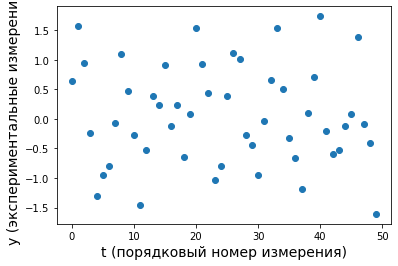

In [3]:
def dataset_stohastic(mu, noise_sigma, data_size, random_state):
    t = np.arange(0, data_size, 1.)
    random.seed(random_state)
    noise = np.empty((data_size, 1))
    y = np.empty((data_size))

    for i in range(data_size):
        noise[i] = random.gauss(mu, noise_sigma)
        y[i] = np.sin(t[i]) + noise[i]

    return t, y

data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
t, y = dataset_stohastic(mu, noise_sigma, data_size, 1)

plt.plot(t, y, 'o') 
plt.xlabel('t (порядковый номер измерения)', fontsize=14)
plt.ylabel('y (экспериментальные измерения)', fontsize=14)

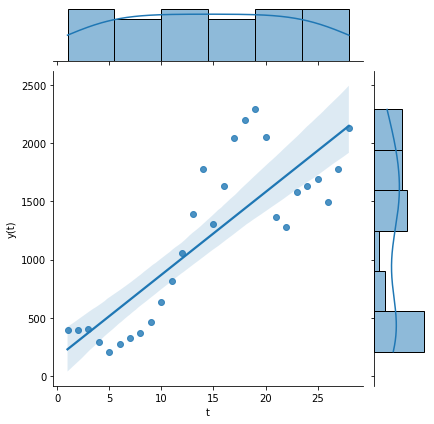

In [28]:
# создаем датафрейм для красивого изображения данных 
# сигнал случайный, формируем одну выборку

d = {'y(t)': y, 't': t}
df = pd.DataFrame(d)
seaborn.jointplot(data=df, x = "t", y = "y(t)",kind='reg')

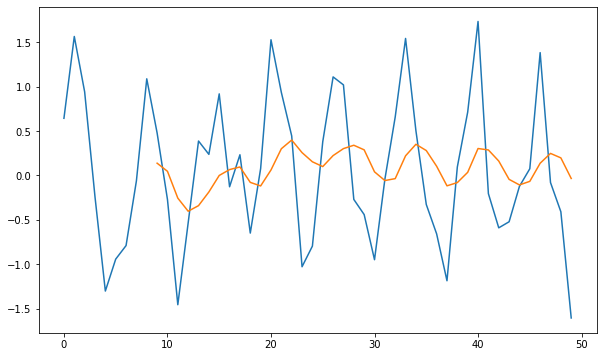

In [5]:
# расчет скользящего среднего
df['y(t)'].plot(figsize=(10,6))
df['y(t)'].rolling(window = 10).mean().plot()
y_mean = df['y(t)'].rolling(window = 10).mean()

         t         y
0      0.0  0.470858
1      1.0  0.143182
2      2.0  0.569440
3      3.0  0.326372
4      4.0 -1.264977
...    ...       ...
1495  45.0  1.063230
1496  46.0  0.273412
1497  47.0  0.494722
1498  48.0 -1.912562
1499  49.0 -0.709930

[1500 rows x 2 columns]


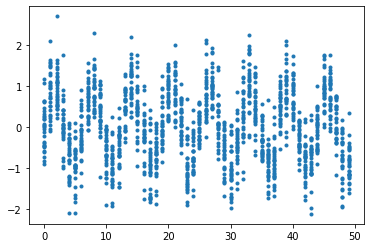

In [6]:
data_size = 50 # размер генерируемого набора данных
noise_sigma = 0.5 # СКО шума в данных
mu = 0 # математическое ожидание
x_cortege = []
y_cortege = []
for i in range(30):
     x_t, y_t = dataset_stohastic(mu, noise_sigma, data_size, i)
     x_cortege = np.append(x_cortege, x_t)
     y_cortege = np.append(y_cortege, y_t)
plt.plot(x_cortege,y_cortege,'.')
dataframe_cortege = {
    "t": x_cortege,
    "y": y_cortege
}
df = pd.DataFrame(dataframe_cortege)

print(df)

<Axes: xlabel='t', ylabel='y'>

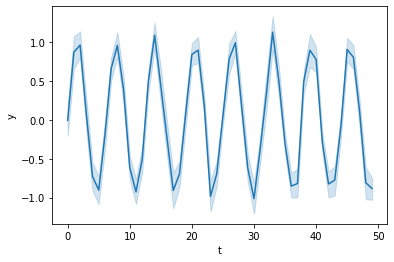

In [7]:
seaborn.lineplot(x = "t", y= "y", data = df, markers = True)

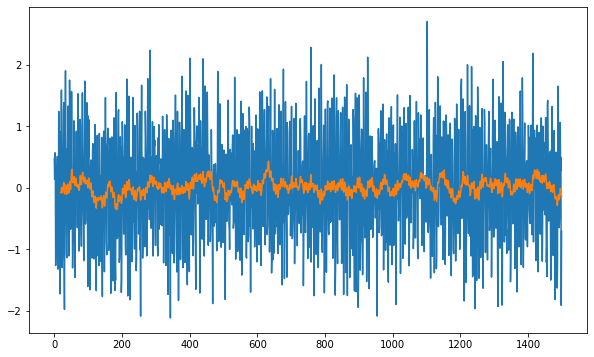

In [8]:
df['y'].plot(figsize=(10,6))
df['y'].rolling(window = 20).mean().plot()
y_mean = df['y'].rolling(window = 20).mean()

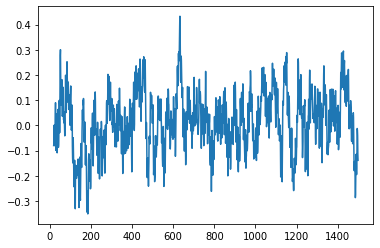

In [9]:
plt.plot(y_mean)

# **Пример обработки файла с историческими данными о курсе доллара к рублю**

In [45]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("UsdRubTime.csv", sep = ';')

x_axis = 'Week'
y_axis = 'Close'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [ ]:
# обработка данных
print(df_data.head)

print(N, T)

In [11]:
# загрузить последовательность из внешнего файла
# загрузить курс доллара
data_file = pd.read_csv("VVP Russia.csv", sep = ';')

x_axis = 'Year'
y_axis = 'GDPusd'

df_data = pd.DataFrame(data_file, columns = [x_axis, y_axis])

y = df_data[y_axis]
T = max(df_data[x_axis])
N = len(df_data[x_axis])
t = np.linspace(1, T, N)

In [12]:
# удалить все данные из файла, которые больше чем заданный параметр
df_data = df_data[df_data.Week > 350]

print(df_data.head)

AttributeError: ignored

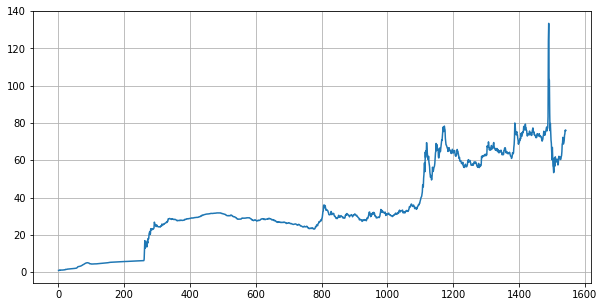

In [46]:
# график временной зависимости
plt.figure(figsize = (10,5))
plt.grid()
plt.plot(t, y)
plt.show()

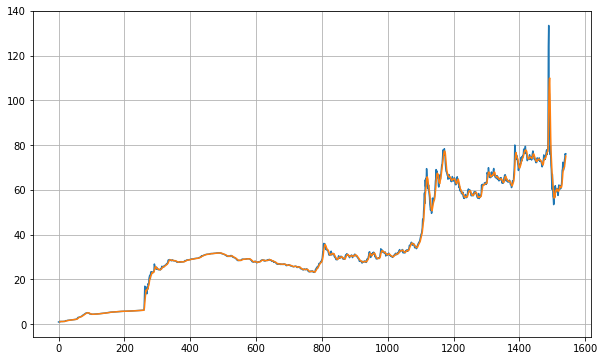

In [47]:
# расчет скользящего среднего
y.plot(figsize=(10,6))
y.rolling(window = 5).mean().plot()
y_mean = y.rolling(window = 5).mean()
plt.grid()
plt.show()

In [15]:
y_mean = y_mean[~np.isnan(y_mean)]
print(y_mean.head)

<bound method NDFrame.head of 4      338.438
5      314.944
6      302.254
7      295.248
8      329.350
9      413.948
10     521.884
11     668.228
12     872.584
13    1136.114
14    1271.396
15    1434.414
16    1631.338
17    1793.536
18    1895.706
19    2045.188
20    1991.360
21    1838.970
22    1714.118
23    1582.402
24    1509.750
25    1535.356
26    1634.824
27    1745.142
Name: GDPusd, dtype: float64>


<function matplotlib.pyplot.show(close=None, block=None)>

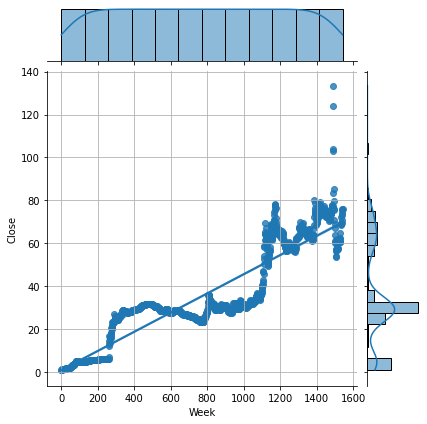

In [48]:
seaborn.jointplot(data = df_data, x = x_axis, y = y_axis, kind='reg')
plt.grid()
plt.show

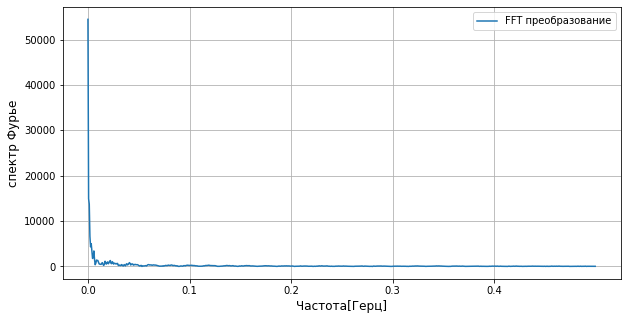

In [49]:
from scipy.fft import fft, fftfreq

yf = fft(y.values)
xf = fftfreq(N, T/N)[:N//2]
# спект Фурье симметричен относительно нуля, поэтому берем только правую его часть
plt.figure(figsize=(10, 5))
plt.plot(xf, np.abs(yf[0:N//2]),label='FFT преобразование')
plt.xlabel('Частота[Герц]', fontsize=12)
plt.ylabel('спектр Фурье', fontsize=12)
plt.xticks(np.arange(0, np.max(xf), 0.1))
#plt.ylim(0,2000)
plt.grid()
plt.legend()
plt.show()

https://www.dmitrymakarov.ru/intro/time-series-20/#2-analiz-vremennykh-ryadov

In [50]:
# автокорреляция
import statsmodels.api as sm

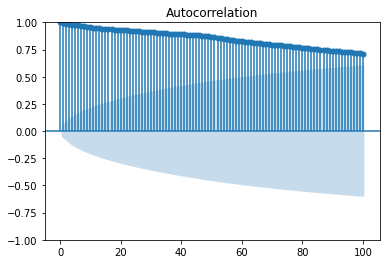

In [52]:
sm.graphics.tsa.plot_acf(y, lags = 100, fft = True)
plt.show()

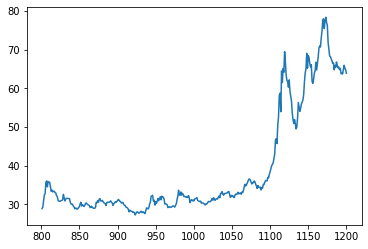

In [53]:
plt.plot(t[800:1200], y[800:1200])


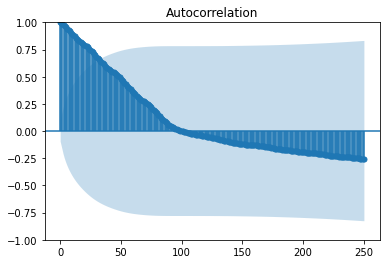

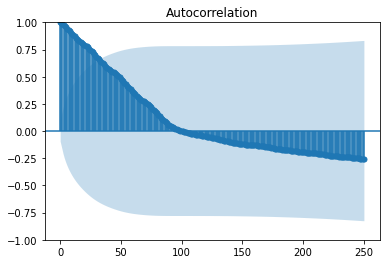

In [54]:
sm.graphics.tsa.plot_acf(y[800:1200], lags = 250)


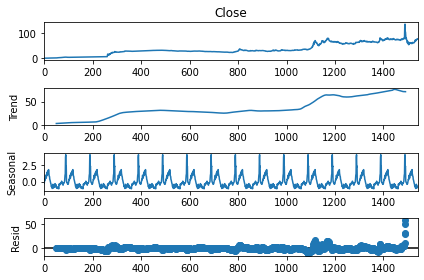

In [58]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose = seasonal_decompose(y, period = 100, model = "additive")
decompose.plot()
 

plt.show()